# Triplet Loss

### Load Train, Test, and Validation data

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/ICDAR-feature/train_features.npy"
train_names_path = "../feature/ICDAR-feature/train_names.npy"
train_labels_path = "../feature/ICDAR-feature/train_labels.npy"

test_features_path = "../feature/ICDAR-feature/test_features.npy"
test_names_path = "../feature/ICDAR-feature/test_names.npy"
test_labels_path = "../feature/ICDAR-feature/test_labels.npy"

validation_features_path = "../feature/ICDAR-feature/validation_features.npy"
validation_names_path = "../feature/ICDAR-feature/validation_names.npy"
validation_labels_path = "../feature/ICDAR-feature/validation_labels.npy"

gallery_feature_path = "../feature/ICDAR-feature/gallery_features.npy"
gallery_name_path = "../feature/ICDAR-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(857, 512)
(857,)
(857,)
(401, 512)
(401,)
(401,)
(391, 512)
(391,)
(391,)
(64, 512)
(64,)


### Creating Triplets

In [4]:
unique_names = set(train_names.flatten())
sorted_names = sorted(unique_names)

In [5]:
print(sorted_names)

['001', '002', '003', '004', '006', '009', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069']


In [6]:
print(gallery_names)

['001' '002' '003' '004' '006' '009' '012' '013' '014' '015' '016' '017'
 '018' '019' '020' '021' '022' '023' '024' '025' '026' '027' '028' '029'
 '030' '031' '032' '033' '034' '035' '036' '037' '038' '039' '040' '041'
 '042' '043' '044' '045' '046' '047' '048' '049' '050' '051' '052' '053'
 '054' '055' '056' '057' '058' '059' '060' '061' '062' '063' '064' '065'
 '066' '067' '068' '069']


In [7]:
def create_triplets(unique_names, gallery_features, features, labels):
    anchors, positives, negatives = [], [], []
    for name, gallery in zip(unique_names, gallery_features):
        # find all the instances for name
        indices = np.where(train_names == name)[0]
        # print(indices)
        
        # separate instances to positive and negative
        positive_set, negative_set = [], []
        for index in indices:
            # print(index)
            if labels[index] == 0:
                negative_set.append(features[index])
                # print(features[index])
            else:
                positive_set.append(features[index]) 

        negative_set = np.array(negative_set)
        positive_set = np.array(positive_set)

        # use feature gallery for anchor
        # print(gallery.size)
        anchor = gallery
        
        # print(positive_set.size)
        # print(negative_set.size)

        # randomize data picks to accomodate for unequal data size (total size is based on negative data size due to it being bigger than positive data size)
        np.random.seed(1)
        anchor_set = []
        if(len(positive_set) < len(negative_set)):
            positive_idx = np.random.choice(len(positive_set), size=len(negative_set), replace=True)
            positive = positive_set[positive_idx]
            negative = negative_set
            for _ in range(0, len(negative_set)):
                anchor_set.append(anchor)
        elif(len(positive_set) > len(negative_set)):
            negative_idx = np.random.choice(len(negative_set), size=len(positive_set), replace=True)
            negative = negative_set[negative_idx]
            positive = positive_set
            for _ in range(0, len(positive_set)):
                anchor_set.append(anchor)
        else:
            positive = positive_set
            negative = negative_set
            for _ in range(0, len(negative_set)):
                anchor_set.append(anchor)

        anchors.append(anchor_set)
        positives.append(positive)
        negatives.append(negative)
        # print(len(anchors))
        # print(len(positives))
        # print(len(negatives))

    anchors = np.concatenate(anchors, axis=0)
    
    positives = np.concatenate(positives, axis=0)

    negatives = np.concatenate(negatives, axis=0)
    
    return anchors, positives, negatives

In [8]:
anchors, positives, negatives = create_triplets(sorted_names, gallery_features, train_features, train_labels)

In [9]:
print("Anchors shape:", anchors.shape)
print("Positives shape:", positives.shape)
print("Negatives shape:", negatives.shape)

Anchors shape: (495, 512)
Positives shape: (495, 512)
Negatives shape: (495, 512)


### Triplet Loss Function

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
input_shape = (train_features.shape[1],)

In [12]:
embedding_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu')
])

In [13]:
def create_triplet_loss_model(embedding_model, input_shape):
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')

    # Get embeddings
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    # Triplet loss function
    margin = 0.625
    positive_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    loss = tf.reduce_mean(loss)

    triplet_loss_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss)
    return triplet_loss_model

In [14]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
Total params: 426880 (1.63 MB)
Trainable params: 426880 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
triplet_model = create_triplet_loss_model(embedding_model, input_shape)
triplet_model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 512)]                0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [17]:
triplet_model.fit([anchors, positives, negatives], np.zeros_like(anchors), epochs=10, batch_size=32)

Epoch 1/10

16/16 [==============================] - 2s 9ms/step - loss: 0.0100
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0071
Epoch 3/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Epoch 5/10
16/16 [==============================] - 0s 9ms/step - loss: 8.4584e-04
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 7.1677e-04
Epoch 8/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Epoch 9/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 10/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0000e+00


In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print(test_labels)

[1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0
 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1
 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0
 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1
 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0
 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1
 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1
 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1
 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0]


In [20]:
train_predictions = embedding_model.predict(train_features)
validation_predictions = embedding_model.predict(validation_features)
test_predictions = embedding_model.predict(test_features)
gallery_predictions = embedding_model.predict(gallery_features)

2/2 [==============================] - 0s 5ms/step


In [21]:
print(train_predictions.shape)
print(validation_predictions.shape)
print(test_predictions.shape)
print(gallery_predictions.shape)

(857, 128)
(391, 128)
(401, 128)
(64, 128)


In [22]:
# Feature Gallery dilakukan untuk setiap kelas / nama seperti "001", "002", "003", dst dengan cara mengambil data training positive dan mengambil mean / rata-rata dari data tersebut
def create_feature_gallery(train_features, train_names, train_labels):
    gallery_feature = []
    gallery_name = []

    unique_names = set(train_names.flatten())
    sorted_names = sorted(unique_names)

    for name in sorted_names:
        # print(name)
        # print(name)
        name_features = []

        for feature, feature_name, label in zip(train_features, train_names, train_labels):
            # print(feature, feature_name, label)
            if name in feature_name and label == 1:
                name_features.append(feature)

        if name_features:
            # print(name_features)
            average_feature = np.mean(name_features, axis=0)
            gallery_feature.append(average_feature)
            gallery_name.append(name)

    return gallery_feature, gallery_name

In [23]:
# gallery_features_extracted, gallery_names_extracted = create_feature_gallery(train_predictions, train_names, train_labels)

In [24]:
# print(gallery_features_extracted)

In [25]:
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1 - feature_vector2)**2))

In [26]:
def find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names):
    euclidean_distances = []
    euclidean_names = []
    euclidean_actual_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_euclid_name = gallery_name
        curr_euclid_feature = []
        curr_euclid_label = []
        curr_euclid_dist = []
        for feature, name, label in zip(test_features, test_names, test_labels):
            if gallery_name in name:
                curr_euclid_feature.append(feature)
                curr_euclid_label.append(label)
        
        for feature in curr_euclid_feature:
            distance = euclidean_distance(feature, gallery_feature)
            curr_euclid_dist.append(distance)

        euclidean_distances.append(curr_euclid_dist)
        euclidean_names.append(curr_euclid_name)
        euclidean_actual_labels.append(curr_euclid_label)
        
    return euclidean_distances, euclidean_names, euclidean_actual_labels

In [27]:
test_euclidean_distances, test_euclidean_names, test_euclidean_actual_labels = find_euclidean_distance(test_predictions, test_names, test_labels, gallery_predictions, gallery_names)
train_euclidean_distances, train_euclidean_names, train_euclidean_actual_labels = find_euclidean_distance(train_predictions, train_names, train_labels, gallery_predictions, gallery_names)
validation_euclidean_distances, validation_euclidean_names, validation_euclidean_actual_labels = find_euclidean_distance(validation_predictions, validation_names, validation_labels, gallery_predictions, gallery_names)

### Normalize Euclidean Distance

In [28]:
# Flatten the lists of distances
flat_test_distances = [item for sublist in test_euclidean_distances for item in sublist]
flat_train_distances = [item for sublist in train_euclidean_distances for item in sublist]
flat_validation_distances = [item for sublist in validation_euclidean_distances for item in sublist]

In [29]:
print(flat_train_distances)

[4.090614, 9.561433, 4.633248, 5.658778, 4.276454, 6.847118, 5.703295, 4.2895627, 5.6011057, 5.404657, 9.790069, 2.0660436, 7.485573, 8.34532, 14.49083, 12.951905, 6.7530193, 9.866902, 5.472255, 8.046626, 4.5578957, 6.942972, 6.8771663, 4.079318, 3.2160285, 4.1416616, 3.0444913, 5.15025, 4.2674584, 5.3207064, 6.0251384, 8.606999, 10.970979, 16.210842, 13.134738, 10.062321, 7.1965313, 26.086803, 3.9403787, 6.2848887, 6.343658, 6.336047, 8.396365, 4.125066, 5.045545, 11.100916, 8.504694, 8.232878, 12.6094885, 7.4880066, 8.565056, 6.3487644, 22.604973, 22.12083, 12.221252, 18.878494, 18.092192, 18.720726, 8.410207, 7.205531, 4.5328274, 5.977479, 5.217064, 4.925484, 4.550821, 6.783599, 5.3535953, 5.293776, 6.684344, 5.443122, 7.5826406, 9.974163, 13.428133, 22.1976, 18.217487, 13.131582, 16.11523, 19.761534, 4.861915, 5.9799414, 10.808481, 10.3006735, 6.494332, 6.652703, 8.3656, 4.5619664, 5.644306, 4.3206024, 9.426956, 6.4784636, 6.630944, 6.976866, 12.521395, 14.992566, 12.264913, 14.306

In [30]:
def get_min_max(euclidean_distances):
    min_distance = min(euclidean_distances)
    max_distance = max(euclidean_distances)

    return min_distance, max_distance

In [31]:
min_val, max_val = get_min_max(flat_train_distances)
print(f'min: {min_val}, max: {max_val}')

min: 1.6230374574661255, max: 33.639495849609375


In [32]:
def normalize_distance(euclidean_distances, min_val, max_val):
    all_distance = []

    for distance in euclidean_distances:
        normalized_distance = (distance - min_val) / (max_val - min_val)

        # in case test and train distances are beyond max of train
        if normalized_distance > 1:
            normalized_distance = 1
        elif normalized_distance < 0:
            normalized_distance = 0
        
        all_distance.append(normalized_distance)

    return all_distance

def reverse_normalized_distance(euclidean_distances, min_val, max_val):
    reverse_distance = []
    normalized_distances = normalize_distance(euclidean_distances, min_val, max_val)
    for distance in normalized_distances:
        distance = -distance
        reverse_distance.append(distance)

    return reverse_distance

In [33]:
normalized_test_euclidean_distance = reverse_normalized_distance(flat_test_distances, min_val, max_val)
normalized_train_euclidean_distance = reverse_normalized_distance(flat_train_distances, min_val, max_val)
normalized_validation_euclidean_distance = reverse_normalized_distance(flat_validation_distances, min_val, max_val)

In [34]:
print(normalized_test_euclidean_distance)

[-0.24948552, -0.22000138, -0.194515, -0.06775997, -0.091127545, -0.2908947, -0.21389803, -0.23116446, -0.11036554, -0.13616548, -0.0852198, -0.104448535, -0.8506845, -0.71713394, -0.6942354, -0.2884454, -0.15854087, -0.12352751, -0.18521693, -0.17884469, -0.38774213, -0.42901105, -0.44053617, -0.190993, -0.15395826, -0.2312901, -0.26142865, -0.27531323, -0.5271584, -0.2947249, -0.6146137, -0.17196493, -0.20482947, -0.16251564, -0.16549578, -0.28886494, -0.37746876, -0.47162986, -0.34763566, -0.16156594, -0.21779048, -0.09741828, -0.13871051, -0.13114776, -0.18715058, -0.33664542, -0.25205708, -0.12078311, -0.10585025, -0.1692481, -0.053622115, -0.03922411, -0.56273097, -0.42558265, -0.29410043, -0.12155546, -0.086121336, -0.17168587, -0.5609445, -0.70254076, -0.5196008, -0.18762922, -0.21493873, -0.10004562, -0.0893559, -0.09965283, -0.29870617, -0.13464047, -0.21785502, -0.1928983, -0.1279195, -0.20950305, -0.095585346, -0.06257727, -0.044905297, -0.4025107, -0.35108572, -0.3914978, 

# 3. ROC Curve

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

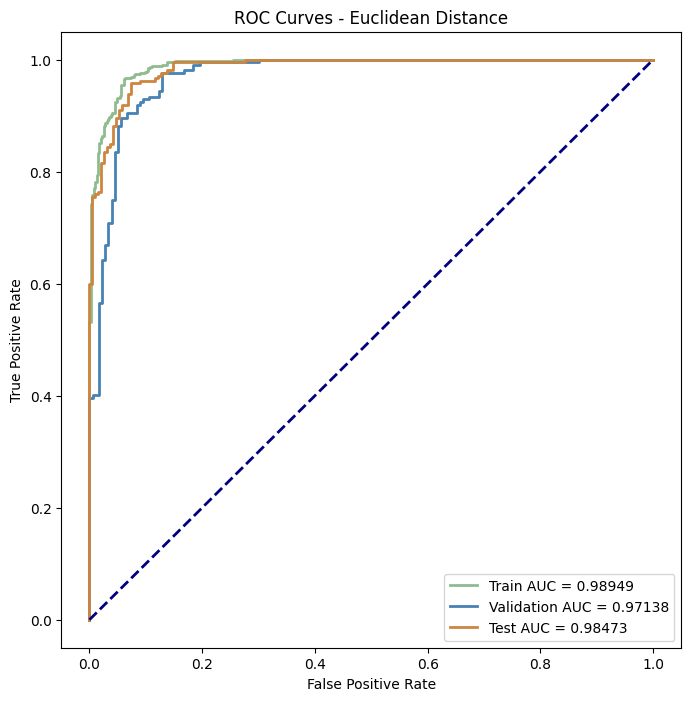

In [36]:
# Flatten the lists of labels
flat_test_labels = [item for sublist in test_euclidean_actual_labels for item in sublist]
flat_train_labels = [item for sublist in train_euclidean_actual_labels for item in sublist]
flat_validation_labels = [item for sublist in validation_euclidean_actual_labels for item in sublist]

# Calculate ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(flat_test_labels, normalized_test_euclidean_distance, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, thresholds_train = roc_curve(flat_train_labels, normalized_train_euclidean_distance, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_validation, tpr_validation, thresholds_validation = roc_curve(flat_validation_labels, normalized_validation_euclidean_distance, drop_intermediate=False)
roc_auc_validation = auc(fpr_validation, tpr_validation)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_validation, tpr_validation, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_validation:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Euclidean Distance')
plt.legend(loc='lower right')
plt.show()

In [37]:
print(tpr_test)

[0.         0.00471698 0.00943396 0.01415094 0.01886792 0.02358491
 0.02830189 0.03301887 0.03773585 0.04245283 0.04716981 0.05188679
 0.05660377 0.06132075 0.06603774 0.07075472 0.0754717  0.08018868
 0.08490566 0.08962264 0.09433962 0.0990566  0.10377358 0.10849057
 0.11320755 0.11792453 0.12264151 0.12735849 0.13207547 0.13679245
 0.14150943 0.14622642 0.1509434  0.15566038 0.16037736 0.16509434
 0.16981132 0.1745283  0.17924528 0.18396226 0.18867925 0.19339623
 0.19811321 0.20283019 0.20754717 0.21226415 0.21698113 0.22169811
 0.22641509 0.23113208 0.23584906 0.24056604 0.24528302 0.25
 0.25471698 0.25943396 0.26415094 0.26886792 0.27358491 0.27830189
 0.28301887 0.28773585 0.29245283 0.29716981 0.30188679 0.30660377
 0.31132075 0.31603774 0.32075472 0.3254717  0.33018868 0.33490566
 0.33962264 0.34433962 0.3490566  0.35377358 0.35849057 0.36320755
 0.36792453 0.37264151 0.37735849 0.38207547 0.38679245 0.39150943
 0.39622642 0.4009434  0.40566038 0.41037736 0.41509434 0.41981132
 

In [38]:
print(fpr_test)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [39]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [40]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_validation, tpr_validation, fpr) for fpr in target_fprs]

In [41]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_validation}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')


Train
TPR at FPR 0.100: 0.978
TPR at FPR 0.010: 0.771
TPR at FPR 0.001: 0.531
             AUC: 0.9894913990637093
Validation
TPR at FPR 0.100: 0.929
TPR at FPR 0.010: 0.401
TPR at FPR 0.001: 0.396
             AUC: 0.9713818910087487
Test
TPR at FPR 0.100: 0.962
TPR at FPR 0.010: 0.755
TPR at FPR 0.001: 0.599
             AUC: 0.9847259658580413


In [42]:
train_features_triplet_loss_path =  "../feature/ICDAR-feature/train_features_triplet_loss.npy"
validation_features_triplet_loss_path = "../feature/ICDAR-feature/validation_features_triplet_loss.npy"
test_features_triplet_loss_path = "../feature/ICDAR-feature/test_features_triplet_loss.npy"
gallery_features_triplet_loss_path = "../feature/ICDAR-feature/gallery_features_triplet_loss.npy"

In [43]:
np.save(train_features_triplet_loss_path, train_predictions)
np.save(test_features_triplet_loss_path, test_predictions)
np.save(validation_features_triplet_loss_path, validation_predictions)
np.save(gallery_features_triplet_loss_path, gallery_predictions)